# Tips for kaggle competition

In [27]:
import numpy as np
import pandas as pd

## Preprocessing-Numerical Features

### Outliers: Clip value range

<AxesSubplot:>

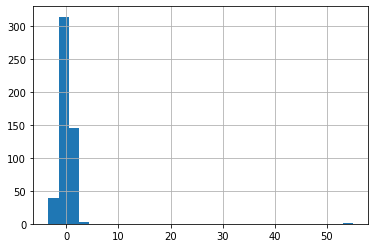

In [25]:
X = pd.Series(np.append(np.random.randn(500),55.0))

X.hist(bins = 30)

<AxesSubplot:>

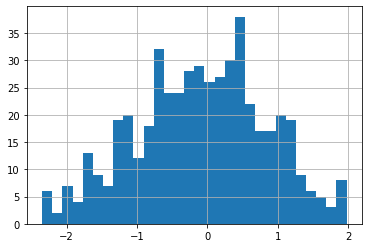

In [26]:
UPPERBOUND, LOWERBOUND = np.percentile(X, [1,99])
y = np.clip(X, UPPERBOUND, LOWERBOUND)
y.hist(bins = 30)

### Outliers: Rank

* It sets spaces between proper assorted values to be equal.
* If there is outliers, this open would be better than MinMaxScaler, because rank transormation will move the outliers closer to other objects.
* Liner models, KNN, and neural networks can benefit from this kind of transformation.

In [31]:
from scipy.stats import rankdata
rankdata([0, 2, 3, 2])

array([1. , 2.5, 4. , 2.5])

<AxesSubplot:>

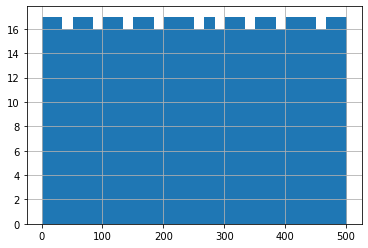

In [37]:
pd.Series(rankdata(X)).hist(bins = 30)

### Log transformation

* for non-tree-based models, especially NN.
* drive too big values closer to the features' average value.
* the values near zero become a bit more distinguishiable.

<AxesSubplot:>

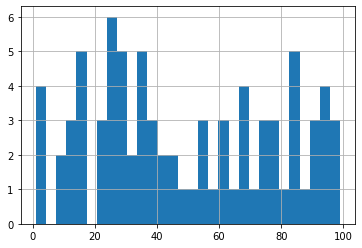

In [42]:
x = np.random.randint(low=1, high=100, size=80)
pd.Series(x).hist(bins = 30)

<AxesSubplot:>

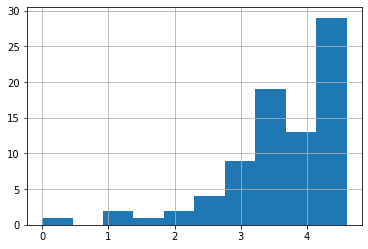

In [51]:
pd.Series(np.log(x)).hist()

<AxesSubplot:>

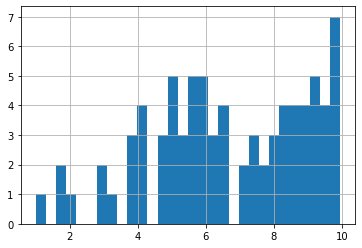

In [52]:
pd.Series(np.sqrt(x)).hist(bins = 30)

### Feature Generation

**Eamples:**
* fractional part of a price
* horizontal + vertical --> direct distance
* other feature intereations.  

## Preprocessing-Categorical Features

* ordianl features: dependence is not linear
    * Label encoding (works fine with tree models)
        * pd.factorize
        * sklearn.preprocessing.LabelEncoder
        * frequency encoding
            * works well with linear models
    * for non-tree models
        * pd.get_dummies
        * OneHotEncoder
        * sparse matrices
    

### Frequency encoding

In [62]:
titanic = pd.read_csv("titanic/train.csv").copy()

In [65]:
encoding = titanic.groupby("Embarked").size()
encoding = round(encoding/len(titanic),1)
titanic['enc'] = titanic.Embarked.map(encoding)

* To Deal with ties:
    * from scipy.stats import rankdata

### Feature Generation


* Simply concatenating clumns

In [74]:
titanic['sex_class'] = titanic['Sex'] + titanic['Pclass'].astype(str)
titanic[['Sex', 'Pclass', 'sex_class']]

,Sex,Pclass,sex_class
0,male,3,male3
1,female,1,female1
2,female,3,female3
3,female,1,female1
4,male,3,male3
...,...,...,...
886,male,2,male2
887,female,1,female1
888,female,3,female3
889,male,1,male1


## Preprocessing-Datetime and coordinates

### Datetime
1. **Periodicity**
    * Day number in week, month, season, year, second, minute, hour.
1. **Time since**
    1. Row-independent moment
    1. Row-dependent moment.
        * Number of days left until next holidays/time passed after holiday.
1. **Difference between dates**

### Coordinates
1. distance to impoortant points on the map.
    1. centers of clusters
1. caculate aggregated statistics for objects surrounding area.
    1. area popularity.

## Missing values

1. Hidden NaNs: histogram

### Fillna approaches

1. -999， -1， etc.
1. mean, median.
    * not for tree 
1. Reconstruct values, row dependencies features.
1. Binary feature "isnull" can be neneficial.
1. In general, avoid filling nans before feature generation.
1. Xgboost can handle NaN

## EDA


1. domain knowledge: understand all the features
1. undertand how the data was generated.
1. check Train/Test/Validation set seperately
1. we may need to modify train set according to the distribution of test set.
    1. inject rows with 0 impressions.
1. plot feature importance.

### find unique combination equivalent to different ID

Find a list of columns so that:

> ```python
df[columns].drop_duplicates().shape[0] == num_of_ID
```

In [19]:
## how to find those columns
# but it may take forever to compute
# sometimes it would be easier to find the combination manually.

import itertools

def find_ncombinations(data):
    # combinations of not more than 5 features
    for n in range(1, 5):
        for c in itertools.combinations(range(data.shape[1]), n):
            print(c)
            columns = test.columns[list(c)]
            if test[columns].drop_duplicates().shape[0] == 639360:
                print(columns)
                return
    print('Nothing found')

In [7]:
import pandas as pd
nunique = pd.Series(
{
"Id":8951040,
"AdGroupId":13548,
"AdGroupName":2281,
"AdNetworkType2":2,
"AveragePosition":131,
"CampaignId":252,
"CampaignName":252,
"Date":14,
"DestinationUrl":52675,
"Device":3,
"KeywordId":12285,
"KeywordMatchType":3,
"KeywordText":11349,
"Slot":4
})

In [16]:
import itertools

# This function looks for a combination of elements 
# with product of 639360 
def find_prod(data):
    # combinations of not more than 5 features
    for n in range(1, 5):
        # iterate through all combinations
        for c in itertools.combinations(range(len(data)), n):
#             print(f"n: {n} === c: {c}")
#             print(data[list(c)].prod())
            if data[list(c)].prod() == 639360:
                print(nunique.index[c])
                return
    print('Nothing found')
    
find_prod(nunique)

Nothing found


Conclusiton:
> * some features are tied;
> * the number of their combination does not equal to product of individual numbers of elements.

```python

# from absolute dates to relative
train['date_diff'] =  (train.Date - train.Date.min()).dt.days

# group by the index, that we've found
g= train.groupby(columns)

# and for each index show average relative date versus 
# the number of rows with that index
plt.figure(figsize=(12,12))
plt.scatter(g.date_diff.mean(),g.size(),edgecolor = 'none',alpha = 0.2, s=20, c='b')
plt.xlabel('Group mean relative date')
plt.ylabel('Group size')
plt.title('Train');

```

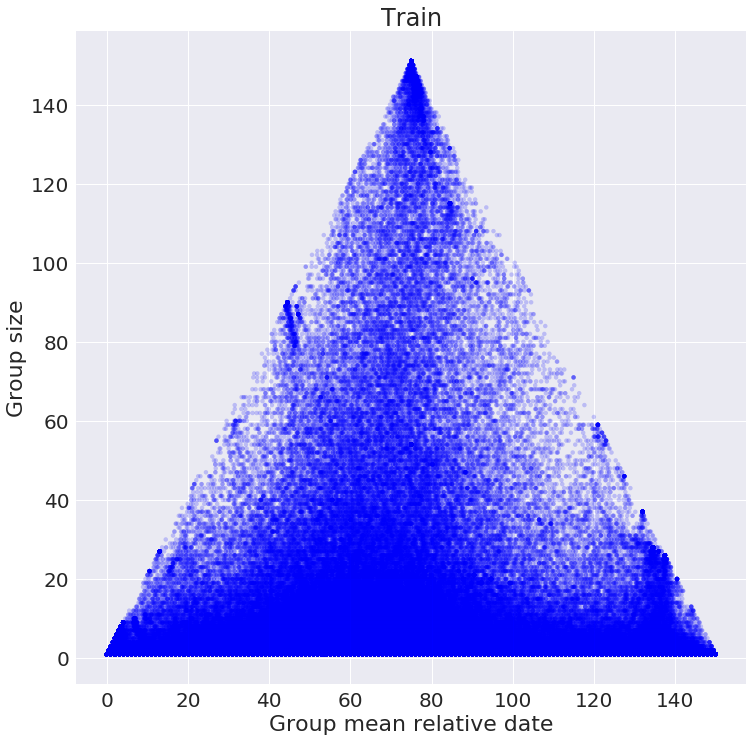

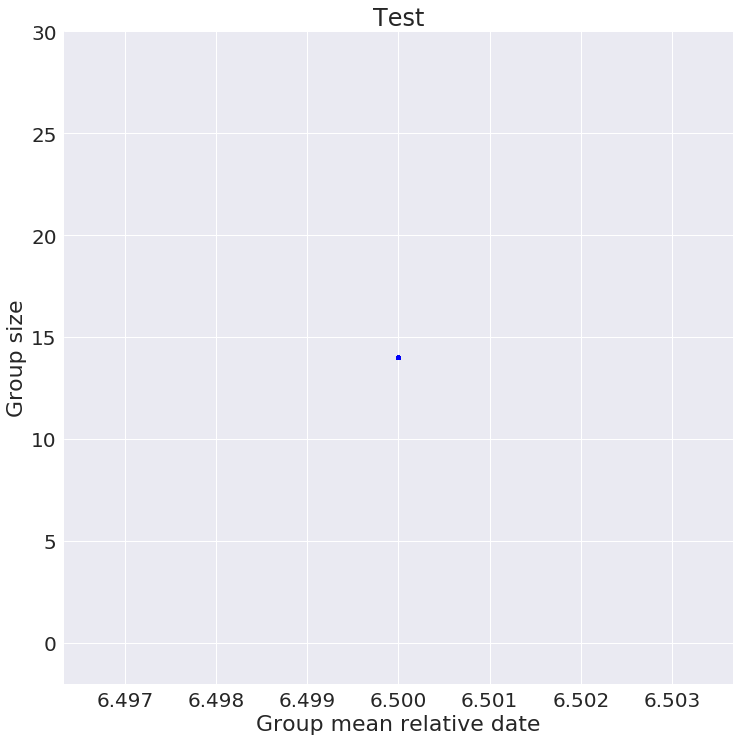

### Anonymized data

- Explore individual features
    - Guess the meaning of the columns
    - Guess the types of the column
- Explore feature relations
    - Find relations btw pairs
    - Find feature groups

### Build Quick Baseline

In [20]:
# from sklearn.ensemble import RandomForestClassifier

# # Create a copy to work with
# X = train.copy()

# # Save and drop labels
# y = train.y
# X = X.drop('y', axis=1)

# # fill NANs 
# X = X.fillna(-999)

# # Label encoder
# for c in train.columns[train.dtypes == 'object']:
#     X[c] = X[c].factorize()[0]
    
# rf = RandomForestClassifier()
# rf.fit(X,y)

In [ ]:
# plt.plot(rf.feature_importances_)
# plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=90)

### Visualisation

Individual features:
1. Histograms
    1. try various bins
    
1. plot (index versus value)
 ```python 
plt.plot(x, ".")
plt.scatter(range(len(x)), x, c=y)
    ```
1. statistics

Feature relations:
* **pairs**
    * sctter plot, scatter matrix
    * corrplot
* **groups**
    * coorplot + clustering
    * plot(index vs. feature statistics)
```python
    plt.scatter(x1,x2)
    pd.scatter_matrix(df)
    df.corr(), plt.mat.matshow()
    df.mean().sort_values(), plot(style = ",")  
```

### Data Cleaning

1. duplicated and constant features
    * remove (row & columns)
    ```python
traintest.T.drop_duplicates()
    ```


### Checkerbord

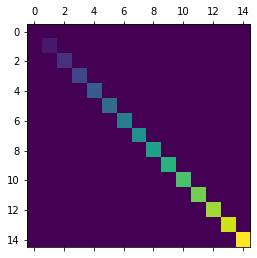

In [30]:
import matplotlib.pyplot as plt
import numpy as np


def samplemat(dims):
    """Make a matrix with all zeros and increasing elements on the diagonal"""
    aa = np.zeros(dims)
    for i in range(min(dims)):
        aa[i, i] = i
    return aa


# Display matrix
plt.matshow(samplemat((15, 15)))

plt.show()

In [32]:
pd.DataFrame(samplemat((15, 15)))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0


consensus score: 1.0


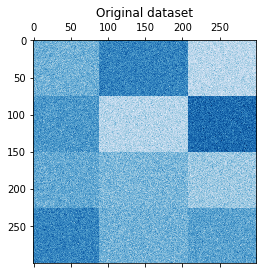

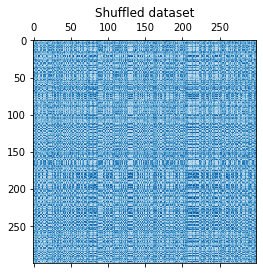

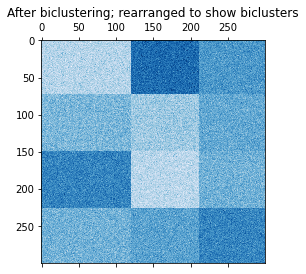

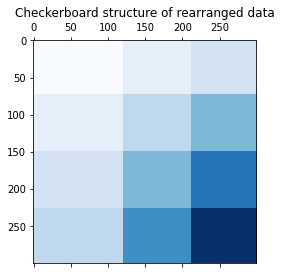

In [22]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_checkerboard
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import consensus_score


n_clusters = (4, 3)
data, rows, columns = make_checkerboard(
    shape=(300, 300), n_clusters=n_clusters, noise=10,
    shuffle=False, random_state=0)

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Original dataset")

# shuffle clusters
rng = np.random.RandomState(0)
row_idx = rng.permutation(data.shape[0])
col_idx = rng.permutation(data.shape[1])
data = data[row_idx][:, col_idx]

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Shuffled dataset")

model = SpectralBiclustering(n_clusters=n_clusters, method='log',
                             random_state=0)
model.fit(data)
score = consensus_score(model.biclusters_,
                        (rows[:, row_idx], columns[:, col_idx]))

print("consensus score: {:.1f}".format(score))

fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

plt.matshow(np.outer(np.sort(model.row_labels_) + 1,
                     np.sort(model.column_labels_) + 1),
            cmap=plt.cm.Blues)
plt.title("Checkerboard structure of rearranged data")

plt.show()
